# Treść zadania


1. Proszę zaimplementować przy użyciu `Executor` i `Future` program wykonujący obliczanie zbioru Mandelbrota w puli wątków.
2. Proszę przetestować szybkość działania programu w zależności od implementacji `Executora` i jego parametrów (np. liczba
   wątków w puli). Czas obliczeń można zwiększać manipulując parametrami problemu, np. liczbą iteracji (`MAX_ITER`).

# Rozwiązanie

## Wstęp

- `Executor` służy do asynchronicznego wykonania zadań typu `Runnable`. Zamiast tworzyć osobne wątki:

  ```java
  new Thread(new(RunnableTask())).start();
  ```

  można użyć metody `execute`:

  ```java
  executor.execute(new RunnableTask1());
  executor.execute(new RunnableTask2());
  ```

- Metoda `ExecutorService#submit` działa podobnie do `execute()`, ale zwraca obiekt typu `Future<T>`, gdzie `T`:

  - Typ, zwracany przez `Callable<T>`, jezeli skorzystano z\
    `ExecutorService#submit(Callable<T> task)` lub\
    `ExecutorService#submit(Runnable task, T result)`
  - `?` jeżeli skorzystano z `ExecutorService#submit(Runnable task)`

- Poszczególne executory można tworzyć w łatwy sposób korzystając z fabryki `Executors`, między innymi zawiera ona
  następujące statyczne metody:

  - `newSingleThreadExecutor`
  - `newFixedThreadPool`
  - `newCachedThreadPool`
  - `newWorkStealingPool`

## Struktura

W trakcie wykonania tego laboratorium powstała następująca struktura:

```
tw-lab8/src/main/java/pl/edu/agh/tw/knapp/lab8
    Main.java
    MandelbrotChunk.java
    MandelbrotVisualizer.java
```

## Opis poszczególnych klas

### `MandelbrotChunk`

Jest to klasa reprezentująca pojedynczy chunk (część) zbioru **Mandelbrot**. W konstruktorze przyjmuje parametry,
w oparciu o które po wywołaniu metody `calculate` zostaną wykonane obliczenia. Parametry to są:

- `startX`, czyli współrzędna **x** początku chunka. Musi być w przedziale $[0, width)$
- `startY`, czyli współrzędna **y** początku chunka. Musi być w przedziale $[0, height)$
- `endX`, czyli współrzędna **x** końca chunka. Musi być w przedziale $(startX, width]$
- `endY`, czyli współrzędna **y** końca chunka. Musi być w przedziale $(startY, height]$
- `translateX`, czyli przemieszczenie poziome
- `translateY`, czyli przemieszczenie pionowe
- `maxIter`, czyli maksymalna liczba iteracji
- `zoom`, czyli skala

Zmieniając parametry `startX`, `startY` oraz `endX`, `endY` można w łatwy sposób zrównoleglić obliczenie tego zbioru.
Warto zwrócić uwagę, że pozostałe parametry muszą być takie same dla wszystkich chunków.

Implementacja wygląda następująco:

```java
// MandelbrotChunk.java

package pl.edu.agh.tw.knapp.lab8;

public class MandelbrotChunk {
    public record Params(
            int startX,
            int startY,
            int endX,
            int endY,
            int translateX,
            int translateY,
            int maxIter,
            double zoom
    ) {
        int getWidth() {
            return endX - startX;
        }

        int getHeight() {
            return endY - startY;
        }
    }

    private final Params params;

    private final int[] rgb;

    public MandelbrotChunk(Params params) {
        this.params = params;
        this.rgb = new int[params.getWidth() * params.getHeight()];
    }

    public void calculate() {
        for (int y = params.startY; y < params.endY; y++) {
            for (int x = params.startX; x < params.endX; x++) {
                double zx = 0;
                double zy = 0;
                double cX = (x - params.translateX) / params.zoom;
                double cY = (y - params.translateY) / params.zoom;
                int iter = params.maxIter;

                while (zx * zx + zy * zy < 4 && iter > 0) {
                    double tmp = zx * zx - zy * zy + cX;
                    zy = 2.0 * zx * zy + cY;
                    zx = tmp;
                    iter--;
                }

                int rgbX = x - params.startX;
                int rgbY = y - params.startY;
                int rgbValue = iter | (iter << 8);

                rgb[rgbY * params.getWidth() + rgbX] = rgbValue;
            }
        }
    }

    public Params getParams() {
        return params;
    }

    public int[] getRgb() {
        return rgb;
    }
}
```

### `MandelbrotVisualizer`

Jest to klasa umożliwiająca wyświetlenie listy przekazanych do niej chunków.

Implementacja wygląda następująco:

```java
// MandelbrotVisualizer.java

package pl.edu.agh.tw.knapp.lab8;

import org.jetbrains.annotations.NotNull;

import javax.swing.*;
import java.awt.*;
import java.awt.image.BufferedImage;
import java.util.List;

public class MandelbrotVisualizer extends JFrame {
    private final BufferedImage image;

    public MandelbrotVisualizer(@NotNull List<MandelbrotChunk> chunks) {
        super("MandelbrotVisualizer");

        int width = chunks.stream().mapToInt(chunk ->
                chunk.getParams().endX()).max().orElseThrow();

        int height = chunks.stream().mapToInt(chunk ->
                chunk.getParams().endY()).max().orElseThrow();

        image = new BufferedImage(width, height, BufferedImage.TYPE_INT_RGB);

        chunks.forEach(chunk -> {
            var params = chunk.getParams();
            var rgb = chunk.getRgb();

            image.setRGB(
                    params.startX(), params.startY(),
                    params.getWidth(), params.getHeight(),
                    rgb,
                    0, params.getWidth());
        });

        setResizable(false);
        setSize(width, height);
        setDefaultCloseOperation(EXIT_ON_CLOSE);
    }

    @Override
    public void paint(Graphics g) {
        g.drawImage(image, 0, 0, this);
    }

    public static void visualize(@NotNull List<MandelbrotChunk> chunks) {
        new MandelbrotVisualizer(chunks).setVisible(true);
    }
}
```

Warto zwrócić uwagę, że żeby wyświetlić wygenerowany obraz nie wystarczy tylko stworzyć egzemplarz
klasy `MandelbrotVisualizer`, należy również wywołać metodę `setVisible(true)`. W celu połączenia
tych dwóch czynności została utworzona statyczna metoda `visualize`.

### `Main`

Jest to klasa główna, zajmująca się parsowaniem parametrów, uruchomieniem obliczeń i wyświetleniem
wyników (jeżeli jest zaznaczone).

- Jeżeli aplikację uruchomiono bez podania żadnych argumentów, zostaną wykorzystane wartości domyślne
- W przeciwnym przypadku, muszą zostać przekazane 10 argumentów:
  1. Szerokość obrazu, `int`
  2. Wysokość obrazu, `int`
  3. Przemieszczenie *x*, `int` \*
  4. Przemieszczenie *y*, `int` \*
  5. Liczba chunków, `int`
  6. Liczba wątków w puli wątków, `int` (dotyczy tylko executora `FIXED_THREAD_POOL`, pozostałe executory
     zignorują tę wartość)
  7. Maksymalna liczba iteracji, `int`
  8. Zoom, `double`
  9. Czy wyświetlać wynikowy obraz czy nie, `boolean`
  10. Typ executora, musi to być jedna z wartości typu `String`:
      - `SINGLE_THREAD` (`Executors.newSingleThreadExecutor`)
      - `FIXED_THREAD_POOL` (`Executors.newFixedThreadPool`)
      - `CACHED_THREAD_POOL` (`Executors.newCachedThreadPool`)
      - `WORK_STEALING_POOL` (`Executors.newWorkStealingPool`)

*\*: przemieszczenie można wycentrować przekazując wartość `TO_CENTER` (`=0x80000000`)*

Ta klasa została zaimplementowana w następujący sposób:

```java
// Main.java

package pl.edu.agh.tw.knapp.lab8;

import java.util.ArrayList;
import java.util.concurrent.ExecutionException;
import java.util.concurrent.ExecutorService;
import java.util.concurrent.Executors;
import java.util.concurrent.Future;
import java.util.function.BiConsumer;
import java.util.function.BiFunction;

public class Main {
    private final static int TO_CENTER = Integer.MIN_VALUE;

    private record Params(
            int width,
            int height,
            int translateX,
            int translateY,
            int n,
            int poolSize,
            int maxIter,
            double zoom,
            boolean visualize
    ) {}

    private record Pair<F, S>(F first, S second) {}

    private enum ExecutorType {
        SINGLE_THREAD,
        FIXED_THREAD_POOL,
        CACHED_THREAD_POOL,
        WORK_STEALING_POOL
    }

    /**
     * The application's entry point
     * @param args The arguments list:<br>
     *             args[0]: Width, `int`<br>
     *             args[1]: Height, `int`<br>
     *             args[2]: X translation, can be set to `TO_CENTER`, `int`<br>
     *             args[3]: Y translation, can be set to `TO_CENTER`, `int`<br>
     *             args[4]: The number of chunks, `int`<br>
     *             args[5]: The number of threads in thread pool, `int`<br>
     *                      Note: this value will be only used if the executor type
     *                      is set to `FIXED_THREAD_POOL`<br>
     *             args[6]: The maximum number of iterations, `int`<br>
     *             args[7]: Zoom, `double`<br>
     *             args[8]: Whether to visualize or just perform calculations,
     *                      `boolean`<br>
     *             args[9]: The executor type, available values: `SINGLE_THREAD`,
     *                      `FIXED_THREAD_POOL`, `CACHED_THREAD_POOL`,
     *                      `WORK_STEALING_POOL`.
     */
    public static void main(String[] args) {
        var params = new Params(800, 600, 400, 300, 16, 8, 570, 150, true);
        var executorService = Executors.newFixedThreadPool(params.poolSize);

        // parse args, if specified
        if (args.length > 0) {
            if (args.length != 10)
                throw new IllegalArgumentException(
                    "expected 10 arguments, got " + args.length);

            BiFunction<Integer, Integer, Integer> translateVal = (value, dim) ->
                    value.equals(TO_CENTER) ? dim / 2 : value;

            var width = Integer.parseInt(args[0]);
            var height = Integer.parseInt(args[1]);

            params = new Params(
                    width,
                    height,
                    translateVal.apply(Integer.parseInt(args[2]), width),
                    translateVal.apply(Integer.parseInt(args[3]), height),
                    Integer.parseInt(args[4]),
                    Integer.parseInt(args[5]),
                    Integer.parseInt(args[6]),
                    Double.parseDouble(args[7]),
                    Boolean.parseBoolean(args[8]));

            executorService = switch (ExecutorType.valueOf(args[9].toUpperCase())) {
                case SINGLE_THREAD -> Executors.newSingleThreadExecutor();
                case FIXED_THREAD_POOL -> Executors.newFixedThreadPool(params.poolSize);
                case CACHED_THREAD_POOL -> Executors.newCachedThreadPool();
                case WORK_STEALING_POOL -> Executors.newWorkStealingPool();
            };
        }

        System.out.printf("time=%s\n", demo(params, executorService));

        executorService.shutdown();
    }

    private static long demo(Params params, ExecutorService executorService) {
        int width = params.width;
        int height = params.height;
        int n = params.n;
        int step = width / n;

        var chunks = new ArrayList<Pair<MandelbrotChunk, Future<?>>>(n);

        BiConsumer<Integer, Integer> mkChunk  = (startX, endX) -> {
            var chunkParams = new MandelbrotChunk.Params(
                    startX, 0,
                    endX, height,
                    params.translateX, params.translateY,
                    params.maxIter, params.zoom);

            var chunk = new MandelbrotChunk(chunkParams);

            chunks.add(new Pair<>(chunk, executorService.submit(chunk::calculate)));
        };

        long startTime = System.currentTimeMillis();

        for (int i = 0; i < n - 1; ++i) {
            int startX = step * i;
            int endX = startX + step;
            mkChunk.accept(startX, endX);
        }

        {
            int startX = step * (n - 1);
            int endX = params.width;
            mkChunk.accept(startX, endX);
        }

        // wait for chunks to calculate
        chunks.forEach(pair -> {
            try {
                pair.second.get();
            } catch (InterruptedException | ExecutionException e) {
                throw new RuntimeException(e);
            }
        });

        long totalTime = System.currentTimeMillis() - startTime;

        if (params.visualize) {
            MandelbrotVisualizer.visualize(chunks.stream().map(Pair::first).toList());
        }

        return totalTime;
    }
}
```

Po uruchomieniu aplikacji bez żadnych parametrów wyświetli się następujący obrazek:

<!-- 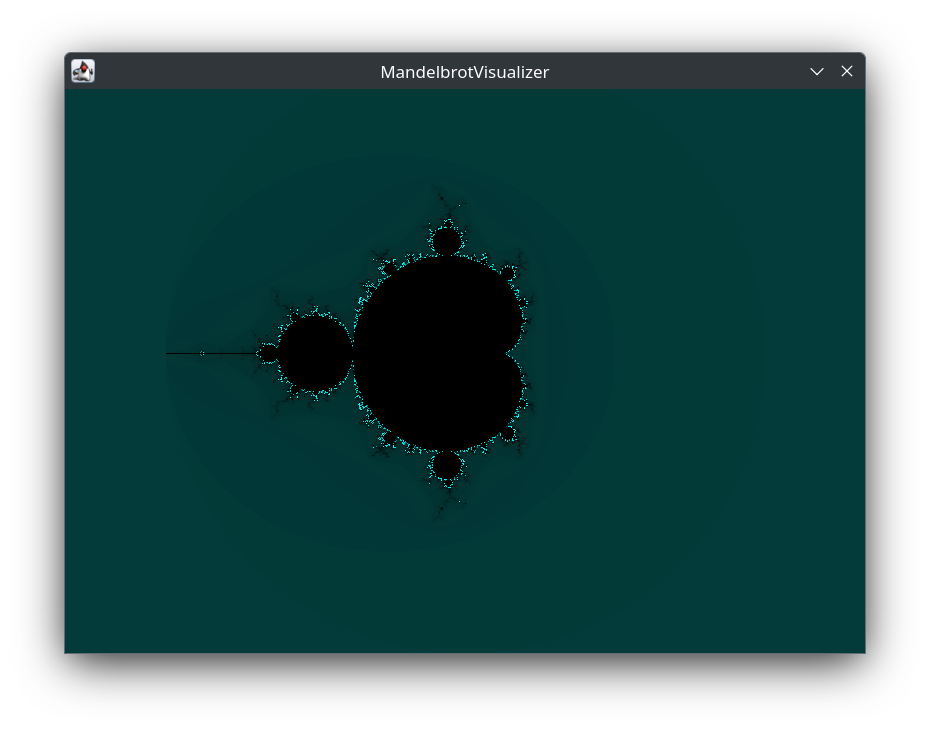 -->
$$\includegraphics[width=10cm]{attachment:Screenshot_20231125_192542.png}$$

Możemy również uruchomić aplikację z nieco innymi parametrami niż domyślne:

```bash
./gradlew run --args="800 600 -700 600 16 8 570 3000 true FIXED_THREAD_POOL"
```

tym razem wyświetli się nieco inny obrazek:

<!-- 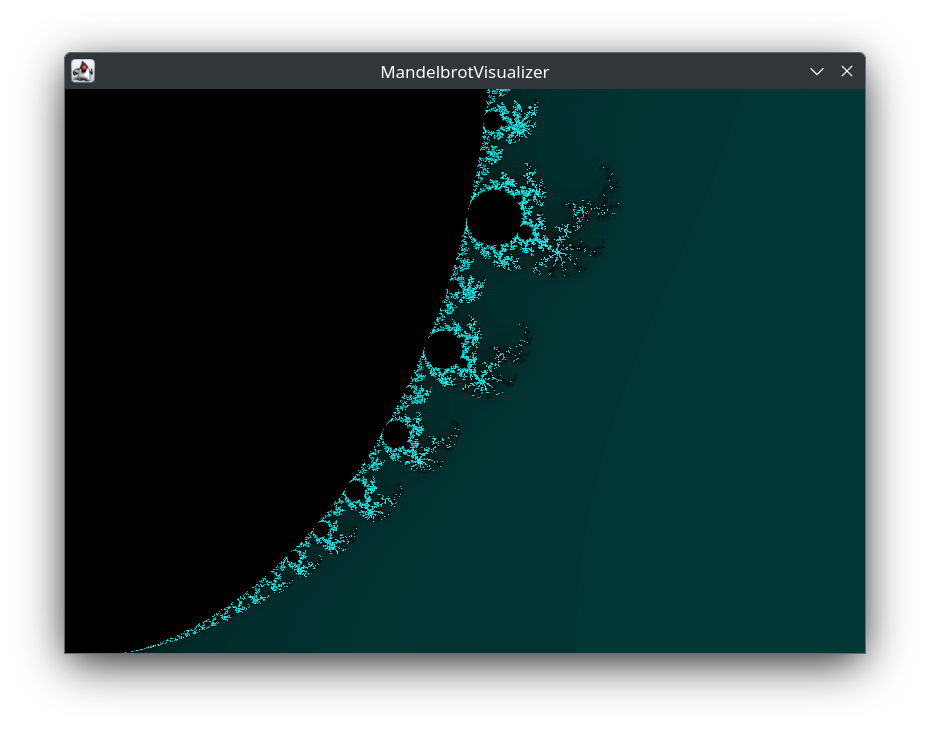 -->
$$\includegraphics[width=10cm]{attachment:Screenshot_20231125_193742.png}$$


Jak już wspomniano wcześniej, zrównoleglenie obliczeń jest osiągane za pomocą podziału zbioru
pikseli na pewne obszary (chunki), każdy z których jest obliczany osobno. W powyższej implementacji
obraz jest dzielony na obszary o tej samej wysokości równej wysokości obrazu, tzn.:

<!-- 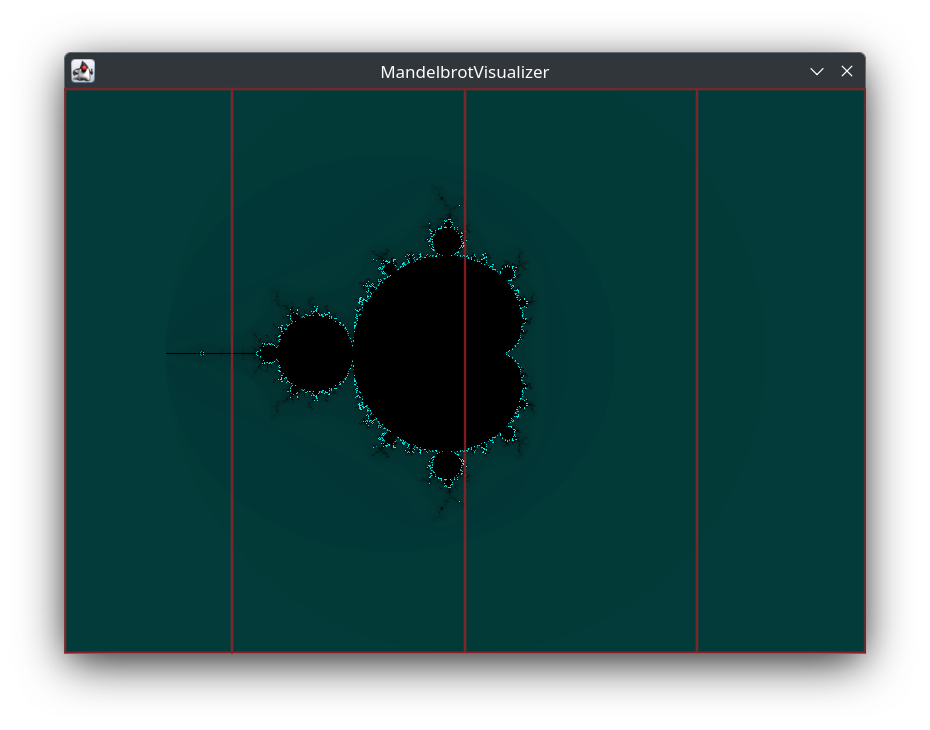 -->
$$\includegraphics[width=10cm]{attachment:Screenshot_20231125_192542_4_chunks.png}$$

jak widać, powyższy obraz został podzielony na 4 *równe* obszary, każdy z których jest reprezentowany
przez osobną instancję `MandelbrotChunk` i jest obliczany osobno.

# Wyniki

W tym rozdziale zostały umieszczone wyniki (pomiary wydajności) w zależności od implementacji executora
i jego parametrów. Wizualne wyniki zostały zaprezentowane w poprzednim rozdziale.

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.5.9-200.fc38.x86_64
- openjdk 17.0.8 2023-07-18

Dodatkowo, w celach otrzymania i przetwarzania wyników został użyty język `python 3.11.6` i następujące biblioteki:

- `matplotlib 3.8.1`, służąca do rysowania wykresów
- `numpy 1.26.1`, służąca do obliczeń numerycznych
- `pandas 2.1.3`, służąca do pracy z danymi tabelarycznymi

Ponadto, żeby ułatwić proces uruchomienia projektu, skorzystano z narzędzia `gradle` (Kotlin DSL).

## Pobieranie wyników

W tej części zostaną pobrane wyniki dla wszystkich w/w executorów.

Wszystkie rozwiązania zostaną przetestowane na wspólnych globalnych (podstawowych) parametrach.

Tworzę funkcję, która będzie wywoływać program Javowy z określonymi parametrami i jako wynik zwracać
czas wykonania obliczeń wypisany przez Javowy program:

In [1]:
import subprocess
import re

def run(width: int,
        height: int,
        translate_x: int,
        translate_y: int,
        chunk_count: int,
        pool_size: int,
        max_iter_count: int,
        zoom: float,
        executor_type: str,
        visualize: bool = False) -> int:
    
    cmd = f"../tw-lab8/gradlew run --args=\"{'{} ' * 10}\"".format(
        width,
        height,
        translate_x,
        translate_y,
        chunk_count,
        pool_size,
        max_iter_count,
        zoom,
        str(visualize).lower(),
        executor_type
    )

    result = subprocess.run(
        ["bash", "-c", cmd],
        cwd="../tw-lab8",
        stdout=subprocess.PIPE)
    
    return int(re.search("time=([0-9]+)", str(result.stdout)).group(1))

In [2]:
import numpy as np

TO_CENTER = np.array(0x80000000).astype(np.int32)

Tworzę funkcję, która dla podanych argumentów zwraca średni czas wykonania:

In [3]:
import numpy as np

def run_mean(n: int, **kwargs) -> float:
    return np.mean([run(**kwargs) for _ in range(n)], dtype=float)

Definiuję globalne (podstawowe, wspólne) parametry:

In [4]:
global_params = {
    "n": 5,
    "width": 1920,
    "height": 1080,
    "translate_x": TO_CENTER,
    "translate_y": TO_CENTER,
    "chunk_count": 16,
    "pool_size": 8,
    "max_iter_count": 4096,
    "zoom": 300,
    "visualize": False,
    "executor_type": "FIXED_THREAD_POOL"
}

Tworzę funkcję tworzącą nowy zbiór (słownik) parametrów w oparciu o `global_params`:

In [5]:
from typing import Any

def get_params(**kwargs) -> dict[str, Any]:
    return global_params | kwargs


Teraz stworzę zbiór parametrów testowych. Warto zauważyć, że różne executory są czułe na zmiany różnych parametrów.
Na przykład, w przypadku `SINGLE_THREAD` nie ma żadnego sensu zmieniać ani rozmiar puli wątków ani liczby chunków -
wszystko jest i tak obliczane w jednym wątku, więc zmiana rozmiaru puli w cale nie będzie miała żadnego wpływu
na wyniki, a zmiana liczby chunków (w granicach rozsądku) prawie nie będzie miała wpływu na ostateczny wynik.

Dla poszczególnych executorów zostaną przetestowane zmiany nastepujących parametrów:

- `SINGLE_THREAD`:
  - `chunk_count`
- `FIXED_THREAD_POOL`:
  - `chunk_count`
  - `pool_size`
- `CACHED_THREAD_POOL`:
  - `chunk_count`
- `WORK_STEALING_POOL`:
  - `chunk_count`

In [6]:
chunk_count_values = np.concatenate([[1], np.arange(2, 31, 4)])
pool_size_values = np.concatenate([[1], np.arange(2, 31, 4)])

Tworzę funkcje generujące parametry:

In [7]:
from typing import Iterable

def param_generator_1d(key: str, values: Iterable[Any], **const_params) -> Iterable[dict[str, Any]]:
    for val in values:
        yield get_params(**({key: val} | const_params))

In [8]:
from typing import Iterable

def param_generator_2d(
        key0: str, values0: Iterable[Any],
        key1: str, values1: Iterable[Any],
        **const_params) -> Iterable[dict[str, Any]]:
    for val0 in values0:
        for val1 in values1:
            yield get_params(**({key0: val0, key1: val1} | const_params))

Tworzę funkcję wykonującą pomiary dla podanego zbioru parametrów i zwracającą wyniki:

In [9]:
import pandas as pd

def runner(param_set: Iterable[dict[str, Any]], columns: list[str]) -> pd.DataFrame:
    result = pd.DataFrame()

    for params in param_set:
        time = run_mean(**params)
        row = pd.DataFrame(dict([(col, params[col]) for col in columns] + [("time", time)]), index=[len(result)])
        result = pd.concat([result, row])

    return result

Wykonuję pomiary:

In [10]:
print("single_thread_df")
single_thread_df = runner(param_generator_1d(
    "chunk_count", chunk_count_values,
    executor_type="SINGLE_THREAD"), ["chunk_count"])

print("fixed_thread_pool_df")
fixed_thread_pool_df = runner(param_generator_2d(
    key0="chunk_count", values0=chunk_count_values,
    key1="pool_size", values1=pool_size_values,
    executor_type="FIXED_THREAD_POOL"), ["chunk_count", "pool_size"])

print("cached_thread_pool_df")
cached_thread_pool_df = runner(param_generator_1d(
    "chunk_count", chunk_count_values,
    executor_type="CACHED_THREAD_POOL"), ["chunk_count"])

print("work_stealing_pool_df")
work_stealing_pool_df = runner(param_generator_1d(
    "chunk_count", chunk_count_values,
    executor_type="WORK_STEALING_POOL"), ["chunk_count"])

single_thread_df
fixed_thread_pool_df
cached_thread_pool_df
work_stealing_pool_df


In [11]:
single_thread_df.head()

,chunk_count,time
0,1,1846.8
1,2,2394.8
2,6,1811.0
3,10,1415.2
4,14,1862.0


In [12]:
fixed_thread_pool_df.head()

,chunk_count,pool_size,time
0,1,1,2272.4
1,1,2,2274.8
2,1,6,2487.0
3,1,10,2496.6
4,1,14,2486.6


In [13]:
cached_thread_pool_df.head()

,chunk_count,time
0,1,2270.4
1,2,1661.4
2,6,1695.4
3,10,1398.8
4,14,1109.4


In [14]:
work_stealing_pool_df.head()

,chunk_count,time
0,1,2487.2
1,2,1830.2
2,6,1702.8
3,10,1408.0
4,14,1126.8


In [15]:
mean_times = pd.DataFrame({
    "name": [
        "single_thread_df",
        "fixed_thread_pool_df",
        "cached_thread_pool_df",
        "work_stealing_pool_df"
    ],
    "time": [
        np.mean(single_thread_df["time"]),
        np.mean(fixed_thread_pool_df["time"]),
        np.mean(cached_thread_pool_df["time"]),
        np.mean(work_stealing_pool_df["time"])
    ]
})

In [16]:
mean_times

,name,time
0,single_thread_df,1695.955556
1,fixed_thread_pool_df,1287.562963
2,cached_thread_pool_df,1247.933333
3,work_stealing_pool_df,1294.577778


Mamy już dane, a więc możemy przejść do rysowania wykresów.

## Wykresy

In [17]:
%config InlineBackend.figure_formats = ['svg']

Tworzę funkcje służące do rysowania 2D oraz 3D wykresów:

In [18]:
def plot2d(df: pd.DataFrame, title: str, x: str = "chunk_count"):
    df.plot(kind="bar", x=x, ylabel="time, $[ms]$", title=title)

In [19]:
import matplotlib.pyplot as plt

def plot3d(df: pd.DataFrame, title: str, x: str = "chunk_count", y: str = "pool_size", z: str = "time", azim: float = -45):
    # set up the figure and axes
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(azim=azim)

    width = 3.5
    depth = 3.5

    ax.bar3d(df[x], df[y], np.zeros_like(df[z]), width, depth, df[z], shade=True)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    plt.show()

Wyświetlam wykresy pokazujące zależności od poszczególnych zmiennych:

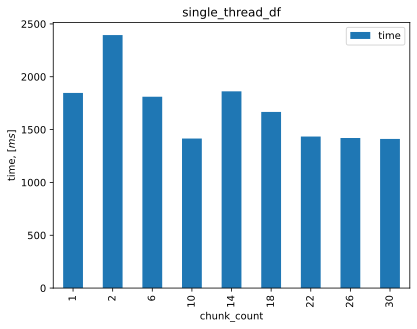

In [20]:
plot2d(single_thread_df, "single_thread_df")

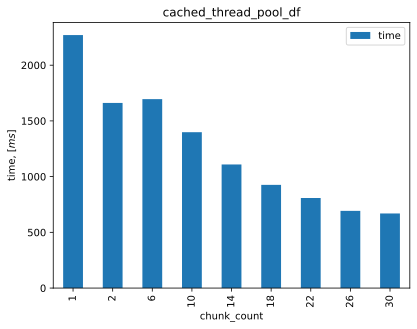

In [21]:
plot2d(cached_thread_pool_df, "cached_thread_pool_df")

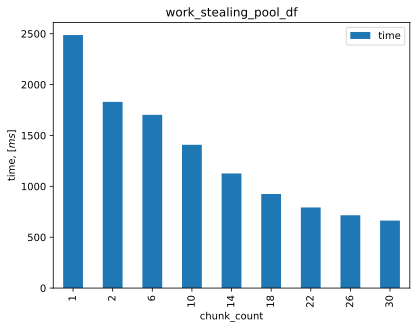

In [22]:
plot2d(work_stealing_pool_df, "work_stealing_pool_df")

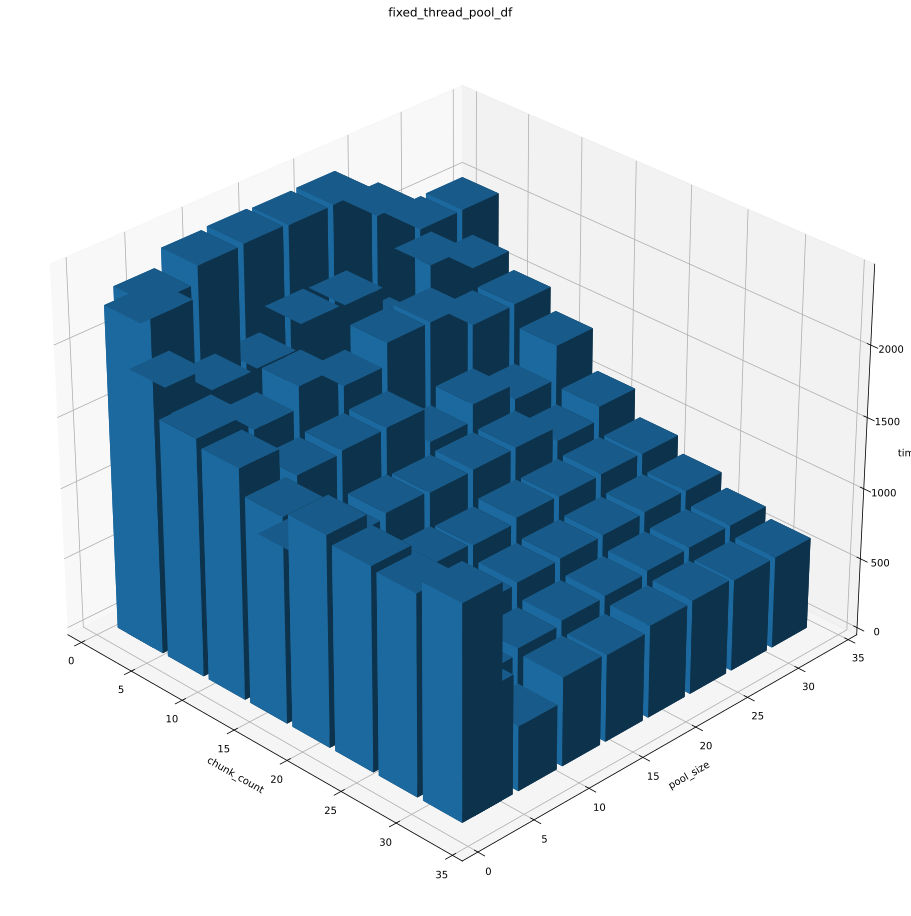

In [23]:
plot3d(fixed_thread_pool_df, "fixed_thread_pool_df")

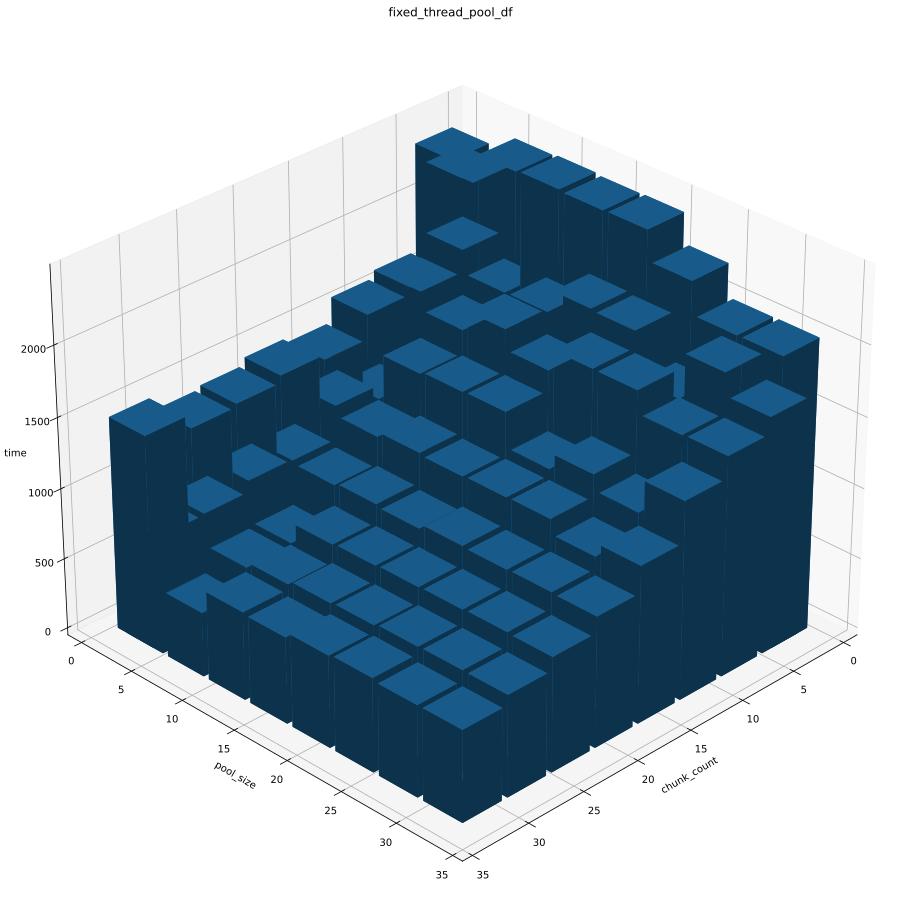

In [24]:
plot3d(fixed_thread_pool_df, "fixed_thread_pool_df", azim=45)

Średnie czasy wykonania:

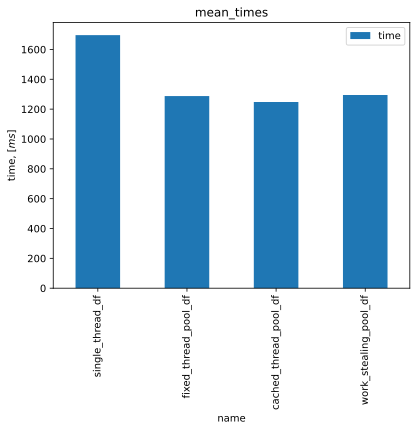

In [25]:
plot2d(mean_times, "mean_times", x="name")

# Wnioski

## Wyniki

Jak widać z powyższych wykresów oraz tabel, implementacja jednowątkowa (`SINGLE_THREAD`) zgodnie z oczekiwaniami
okazała się najwolniejsza i z grubsza nie zależy od liczby chunków. Średni czas wykonania w pozostałych przypadkach
jest w przybliżeniu taki sam.

Ranking implementacji według wydajności (średniego czasu wykonania):

In [28]:
mean_times.sort_values(by="time", ascending=True, ignore_index=True)

,name,time
0,cached_thread_pool_df,1247.933333
1,fixed_thread_pool_df,1287.562963
2,work_stealing_pool_df,1294.577778
3,single_thread_df,1695.955556


W przypadku `FIXED_THREAD_POOL` mamy dużo więcej danych, a więc wynik jest dokładniejszy. Ale również warto
zwrócić uwagę, że ilość danych wynika z tego, że dla tej implementacji zostały wykonane pomiary w zależności
od dwóch zmiennych: liczby chunków oraz rozmiaru puli wątków.

Na podstawie wykresów można dojść do wniosku, że od pewnego momentu nie ma sensu zwiększać ani liczby chunków
ani rozmiaru puli wątków.

**Implementacja `CACHED_THREAD_POOL`** okazała się najszybsza:

> ```java
> public static ExecutorService newCachedThreadPool()
> ```
>
> Creates a thread pool that creates new threads as needed, but will reuse previously constructed threads when they
> are available. **These pools will typically improve the performance of programs that execute many short-lived asynchronous
> tasks**. Calls to execute will reuse previously constructed threads if available. If no existing thread is available, a
> new thread will be created and added to the pool.

jak wynika z dokumentacji, jest to najlepszy wybór w przypadku gdy mamy dużo szybko wykonujących się zadań.

**Implementacja `FIXED_THREAD_POOL`** tworzy pulę wątków ze stałą liczbą aktywnych wątków:

```java
public static ExecutorService newFixedThreadPool(int nThreads)
```

> Creates a thread pool that reuses a fixed number of threads operating off a shared unbounded queue. At any point, at
> most nThreads threads will be active processing tasks. If additional tasks are submitted when all threads are active,
> they will wait in the queue until a thread is available. If any thread terminates due to a failure during execution
> prior to shutdown, a new one will take its place if needed to execute subsequent tasks. The threads in the pool will
> exist until it is explicitly shutdown.

**Implementacja `WORK_STEALING_POOL`** (`Executors#newWorkStealingPool()`) tworzy pulę wątków, używając liczby dostępnych
procesorów *logicznych* jako docelowego poziomu równoległości:

> ```java
> public static ExecutorService newWorkStealingPool()
> ```
>
> Creates a work-stealing thread pool using the number of available processors as its target parallelism level.

> ```java
> public static ExecutorService newWorkStealingPool(int parallelism)
> ```
>
> Creates a thread pool that maintains enough threads to support the given parallelism level, and may use multiple
> queues to reduce contention. The parallelism level corresponds to the maximum number of threads actively engaged in,
> or available to engage in, task processing. The actual number of threads may grow and shrink dynamically.

jak wynika z dokumentacji, taka pula wątków będzie podtrzymywać docelowy poziom równoległości. Liczba wątków może
zmieniać się dynamicznie w zależności od potrzeb (ale nie więcej niz maksymalny poziom równoległości).

**Implementacja `SINGLE_THREAD_POOL`** wykonuje wszystkie zadania sekwencyjnie w jednym wątku:

> ```java
> public static ExecutorService newSingleThreadExecutor()
> ```
>
> Creates an Executor that uses a single worker thread operating off an unbounded queue. (Note however that if this
> single thread terminates due to a failure during execution prior to shutdown, a new one will take its place if needed
> to execute subsequent tasks.) Tasks are guaranteed to execute sequentially, and no more than one task will be active
> at any given time. Unlike the otherwise equivalent `newFixedThreadPool(1)` the returned executor is guaranteed not to be
> reconfigurable to use additional threads.

## Uwagi

- Wiarygodność otrzymanych wyników można poprawić korzystając z większej liczby "uśredniających" iteracji

## Podsumowanie

- **`Executor` to interfejs** w Javie, **umożliwiający asynchroniczne wykonywanie zadań**. Zamiast tworzyć nowe wątki dla
  każdego zadania, `Executor` pozwala na ich wykonywanie w puli wątków, co jest bardziej wydajne

- **Fabryka `Executors`** dostarcza kilka statycznych metod, które **ułatwiają tworzenie różnych typów executorów**. Na przykład:
  - `newSingleThreadExecutor` tworzy executor, który wykonuje zadania w pojedynczym wątku
  - `newFixedThreadPool` tworzy pulę wątków o stałej liczbie wątków
  - `newCachedThreadPool` tworzy pulę wątków, która dynamicznie dostosowuje liczbę wątków do liczby zadań
  - `newWorkStealingPool` tworzy pulę wątków, która podtrzymuje pewną zadaną liczbę wątków, dynamicznie dostosowując się
    do potrzeb

# Bibliografia

1. Materiały do laboratorium, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab8/](https://home.agh.edu.pl/~funika/tw/lab8/)

2. Mandelbrot set (Java implementation), Rosetta Code:\
   [https://rosettacode.org/wiki/Mandelbrot_set#Java](https://rosettacode.org/wiki/Mandelbrot_set#Java)

3. `Executors`, Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/Executors.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/Executors.html)

4. Mandelbrot set, Wikipedia:\
   [https://en.wikipedia.org/wiki/Mandelbrot_set](https://en.wikipedia.org/wiki/Mandelbrot_set)